# **Introduction**





Forecasting taxi demand in a metropolitan city like New York is crucial for optimizing resource allocation, reducing wait times, and improving overall transportation efficiency. Understanding past demand patterns helps in making data-driven decisions for fleet management and traffic control.



---






# **Data Description**

The dataset, sourced from Kaggle, contains time-stamped taxi demand data recorded at 30-minute intervals. It consists of the following variables:

* Timestamp: The date and time when the taxi demand was recorded.

* Value: The number of taxi rides recorded per time interval.

In [ ]:
# Loading libraries
library(tidyverse)
library(lubridate)
library(zoo)
library(forecast)

In [ ]:
taxi_data <- read.csv("/kaggle/input/newyork-city-taxi-trip-records-dataset/dataset.csv")
head(taxi_data)

,X,timestamp,value
,<int>,<chr>,<int>
1,0,2014-07-01 00:00:00,10844
2,1,2014-07-01 00:30:00,8127
3,2,2014-07-01 01:00:00,6210
4,3,2014-07-01 01:30:00,4656
5,4,2014-07-01 02:00:00,3820
6,5,2014-07-01 02:30:00,2873


In [ ]:
str(taxi_data)
summary(taxi_data)


'data.frame':	10320 obs. of  3 variables:
 $ X        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ timestamp: chr  "2014-07-01 00:00:00" "2014-07-01 00:30:00" "2014-07-01 01:00:00" "2014-07-01 01:30:00" ...
 $ value    : int  10844 8127 6210 4656 3820 2873 2369 2064 2221 2158 ...


       X          timestamp             value      
 Min.   :    0   Length:10320       Min.   :    8  
 1st Qu.: 2580   Class :character   1st Qu.:10262  
 Median : 5160   Mode  :character   Median :16778  
 Mean   : 5160                      Mean   :15138  
 3rd Qu.: 7739                      3rd Qu.:19839  
 Max.   :10319                      Max.   :39197  

In [ ]:
# Converting the timestamp column to datetime
taxi_data$datetime <- as.POSIXct(taxi_data$timestamp, format="%Y-%m-%d %H:%M:%S")


In [ ]:
#Aggregating demand at daily level
library(dplyr)

daily_traffic <- taxi_data %>%
  mutate(date = as.Date(datetime)) %>%
  group_by(date) %>%
  summarise(traffic_count = sum(value))

The data was preprocessed by converting timestamps into datetime format and aggregating demand at the daily level for better trend analysis




---



# **Exploratory Data Analysis**

**Time Series Visualization**
A line plot of daily taxi demand was generated using ggplot2 to identify trends and patterns. The visualization suggests:

* A long-term trend where demand fluctuates over time.

* Possible seasonality, with repeating high and low demand periods.

* Short-term spikes, possibly due to external factors like weather or events

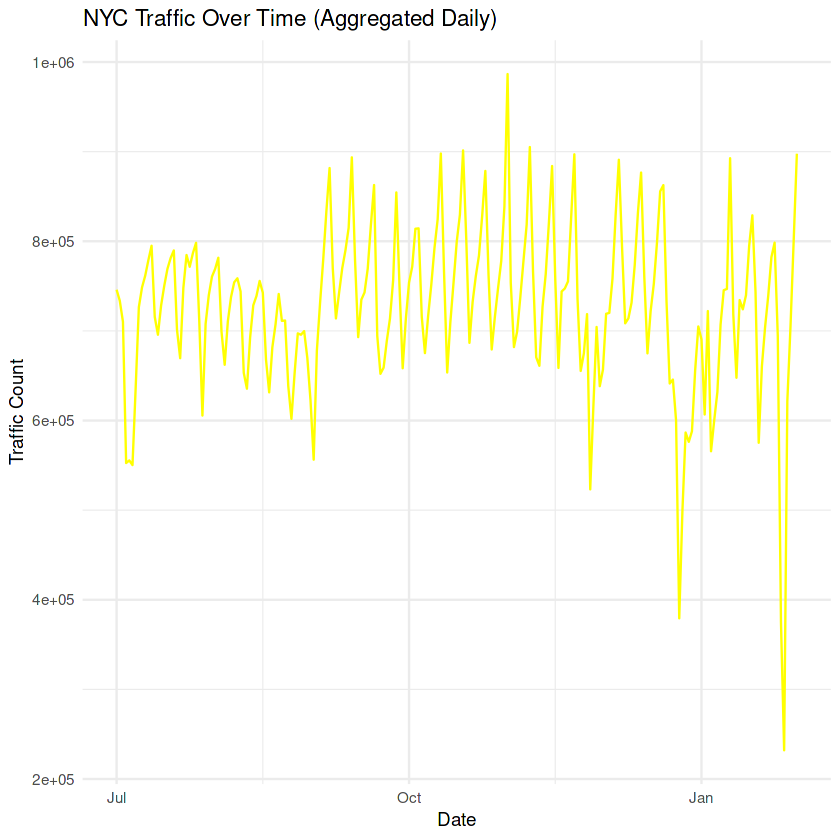

In [ ]:
library(ggplot2)

ggplot(daily_traffic, aes(x = date, y = traffic_count)) +
  geom_line(color = "yellow") +
  labs(title = "NYC Traffic Over Time (Aggregated Daily)",
       x = "Date",
       y = "Traffic Count") +
  theme_minimal()



---



# **Stationarity Testing**

**Why is Stationarity Important?**
A time series is stationary if its statistical properties (mean, variance, autocorrelation) remain constant over time. Stationary time series are crucial because:

* Predictability – Most forecasting models, including ETS, assume stationarity for reliable predictions.

* Autocorrelation Interpretation – ACF and PACF plots provide meaningful insights only when the series is stationary.

* Model Selection – Non-stationary series may require differencing or transformations before applying forecasting models.



1.  **Augmented Dickey-Fuller (ADF) Test**




In [ ]:
library(tseries)
adf_test <- adf.test(traffic_ts)
print(adf_test)


	Augmented Dickey-Fuller Test

data:  traffic_ts
Dickey-Fuller = -3.6106, Lag order = 5, p-value = 0.0334
alternative hypothesis: stationary



Since the p-value is below 0.05, we reject the null hypothesis, indicating that the series is stationary.




2.   **KPSS Test**



In [ ]:
kpss_test <- kpss.test(traffic_ts)
print(kpss_test)

Warning message in kpss.test(traffic_ts):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  traffic_ts
KPSS Level = 0.28543, Truncation lag parameter = 4, p-value = 0.1



The high p-value suggests that we fail to reject the null hypothesis, supporting the claim that the series is stationary.

Since both tests confirm stationarity, no additional transformations are required.





---



# **Autocorrelation and Partial Autocorrelation Analysis**

**Autocorrelation Function (ACF) Plot**

The ACF plot shows how current values of the time series are correlated with past values (lags).

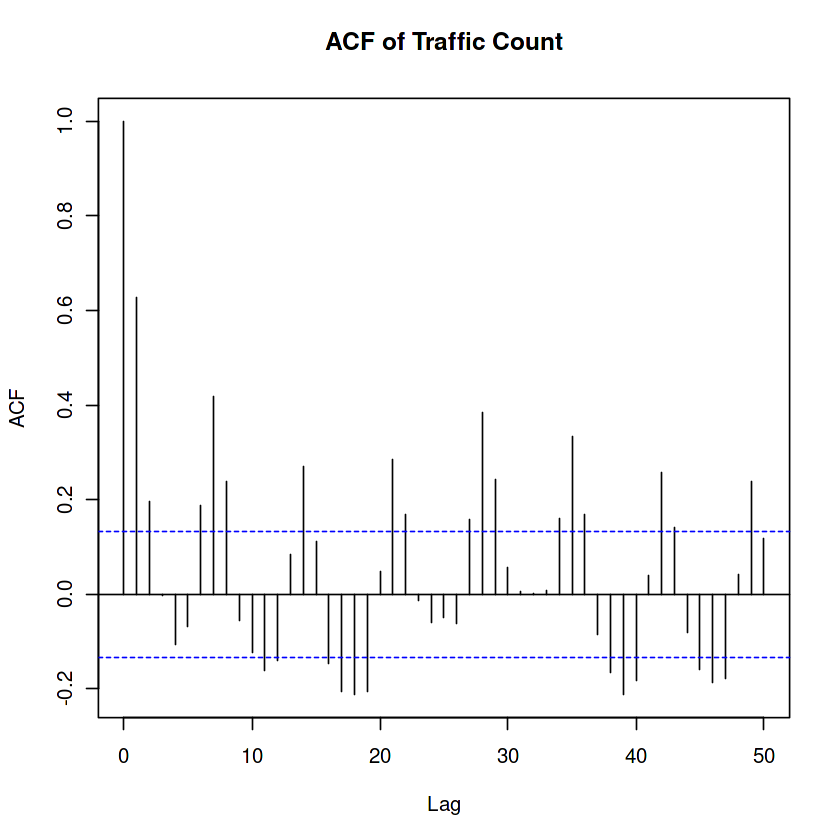

In [ ]:
# plotting acf
par(mfrow=c(1,1))
acf(daily_traffic$traffic_count, lag.max=50, main="ACF of Traffic Count")

**Partial Autocorrelation Function (PACF) Plot**

The PACF plot measures direct correlations by removing the effects of intermediate lags

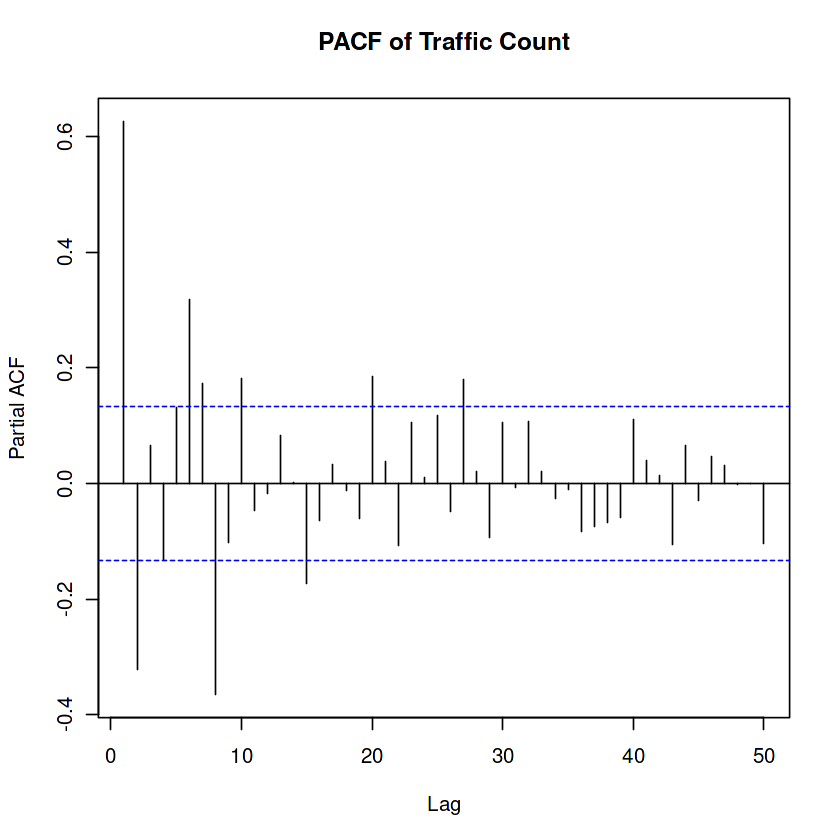

In [ ]:
#plotting pacf
pacf(daily_traffic$traffic_count,lag.max=50, main="PACF of Traffic Count")



---



# **Forecasting Using ETS Mode**

The Exponential Smoothing State Space Model (ETS) was chosen for its ability to capture different components of a time series:

* E (Error): Determines whether the error term follows an additive or multiplicative structure.

* T (Trend): Identifies the presence of an increasing or decreasing trend.

* S (Seasonality): Captures repeating patterns over fixed intervals.

In [ ]:
traffic_ts <- ts(daily_traffic$traffic_count, start = c(2023, 1), frequency = 365)

In [ ]:
library(forecast)

# Fitting ETS model
ets_model <- ets(traffic_ts)

# Printing model summary
summary(ets_model)


ETS(A,N,N) 

Call:
ets(y = traffic_ts)

  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
    l = 685786.821 

  sigma:  79791.59

     AIC     AICc      BIC 
6012.162 6012.276 6022.274 

Training set error measures:
                   ME    RMSE      MAE        MPE     MAPE MASE       ACF1
Training set 985.7845 79419.6 59941.87 -0.7438801 8.931206  NaN 0.08872302

**Model Selection**
The selected model is ETS(A, N, N):

* A (Additive Error)

* N (No Trend)

* N (No Seasonality)

**Model Parameters & Performance**
* Smoothing parameter (alpha): 0.9999 → Indicates strong reliance on recent data points.

* Initial level: 685,786.821

* Sigma (error term): 79,791.59

**Evaluation Metrics**
* Root Mean Squared Error (RMSE): 79,419.6

* Mean Absolute Percentage Error (MAPE): 8.93%

* Akaike Information Criterion (AIC): 6012.162

Lower RMSE and AIC values suggest that the ETS model fits the data reasonably well.

# **Forecasting Results**

In [ ]:
forecasted_traffic <- forecast(ets_model, h = 30)

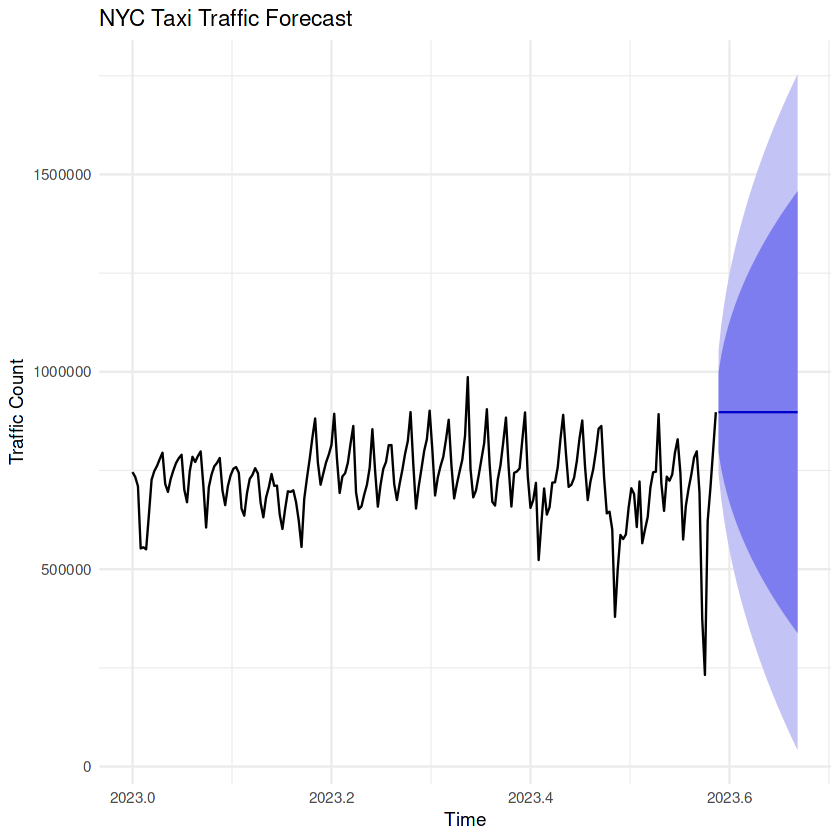

In [ ]:
autoplot(forecasted_traffic) +
  labs(title = "NYC Taxi Traffic Forecast",
       x = "Time",
       y = "Traffic Count") +
  theme_minimal()

A 30-day forecast was generated using the ETS model, and the predictions were visualized with autoplot(forecasted_traffic).

**Interpretation of Forecast**

* The forecasted values show stable demand with some fluctuations.

* Since no seasonality was detected, the forecast follows a smooth trajectory.

* The prediction interval increases over time, indicating growing uncertainty.